In [1]:
%matplotlib inline
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from numpy import sqrt, sin, cos, pi, cosh, sinh, tanh, exp, linalg, log
from sympy import symbols, solve
import math
from  scipy.sparse.linalg import eigsh

In [2]:
def Gibbs(qtilde,x0,z):
  p = 0.5
  h = qtilde * x0 + sqrt(qtilde) * z
  return tanh(h)/(1 + exp(qtilde/2)*(1-2*p)/(2*p * cosh(h) ))

def Gauss(z):
  return exp(-z*z/2)/sqrt(2*pi)

def ExpectGibbsRad(qtilde):
  p = 0.5
  BOUNDS = 10
  #x0 = 1  
  av_fp = lambda z: Gauss(z) * p * (Gibbs(qtilde,1,z))**2
  av_plus, err = integrate.quad(av_fp, -BOUNDS, BOUNDS)
  #x0 = -1  
  av_fm = lambda z: Gauss(z) * p * (Gibbs(qtilde,-1,z))**2
  av_minus, err = integrate.quad(av_fm, -BOUNDS, BOUNDS)
  #x0 = 0
  av_fz = lambda z: Gauss(z) * (1-2*p) * (Gibbs(qtilde,0,z))**2
  av_zero, err= integrate.quad(av_fz, -BOUNDS, BOUNDS)
  return av_plus + av_zero + av_minus

def ExpectGibbs(qtilde,prior):
  if(prior == 'gaussian'):
        return 1 - 1/(qtilde + 1)
  elif prior == 'rademacher':
        return ExpectGibbsRad(qtilde)

def iterate(overlaps, proportions, block_delta, prior):

  averages = [ExpectGibbs(overlap, prior) for overlap in overlaps]
  new_overlaps = [np.dot(proportions / block_delta[i], averages) for i in range(len(proportions))]  

  damping = 0.2
  new_overlaps, overlaps = np.array(new_overlaps), np.array(overlaps)

  return (1-damping) * new_overlaps + damping * overlaps, np.sqrt(np.sum((overlaps - new_overlaps)**2))
def Solve_overlaps(overlaps, proportions, block_delta, prior):
    convergence = 1000
    while (convergence > 1e-3):
        overlaps, convergence = iterate(overlaps, proportions, block_delta, prior)
        
    return overlaps

In [3]:
def optimal_curve(start, end, points, proportions, block_delta, prior):

    MMSEVec = []
    paramvec = []

    param_range = np.linspace(start, end, points)

    for param in param_range:
    
      overlaps = [1] * len(proportions)
    
      overlaps = Solve_overlaps(overlaps, proportions, param * block_delta, prior)
        
      total_overlap = 0
      for block in range(len(proportions)):
          total_overlap += proportions[block] * ExpectGibbs(overlaps[block], prior)
      MMSEVec.append(1 - total_overlap)
      paramvec.append(param)
    
    return {'parameter': paramvec, 'mse': MMSEVec}


In [4]:
def create_block_matrix(sizes, block_delta): 
    #Returns a symmetric matrix consisting of q blocks with prescribed sizes and values 
    N = sum(sizes)
    
    blocks_belonging = []
    for current_block in range(len(sizes)):
        size = sizes[current_block]
        blocks_belonging += [current_block] * size
        
    delta = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            i_block, j_block = blocks_belonging[i], blocks_belonging[j]
            delta[i][j] = block_delta[i_block][j_block]
    return delta

def create_block_matrix_collection(start, end, points, sizes, block_delta):
    N = sum(sizes)
    parameter_range = np.linspace(start, end, points)
    delta_collection = []
    for parameter in parameter_range:
        delta_collection.append(create_block_matrix(sizes, block_delta * parameter))
    return np.array(delta_collection)

def get_instance(dimension, prior, delta):
    #Returns a ground truth vector and the matrix corrupted by a gaussian noise according to the model
    if prior == 'gaussian':
        true_vector = np.random.normal(0,1, size = (dimension, 1))    
    elif prior == 'rademacher':
        true_vector = np.random.choice([-1,1], size = (dimension, 1))
        
    noise = np.triu(np.random.normal(0, 1, (dimension,dimension)))
    noise = noise + noise.T + np.diag(np.random.normal(0,1, dimension))
    
    corrupted_matrix = np.sqrt(1 / dimension) * true_vector @ true_vector.T + noise * np.sqrt(delta)

    return true_vector, corrupted_matrix

def get_mse(truth, estimate):
    truth = truth.flatten()
    estimate = estimate.flatten()
    return min(np.mean((truth - estimate)**2), np.mean((truth + estimate)**2)) #It is impossible to learn the sign

def denoiser_and_derivative(to_denoise, kappa, *, prior):
    if(prior == 'gaussian'):
        return to_denoise /(1 + kappa), 1 / (1 + kappa) 
    elif prior == 'rademacher':
        return np.tanh(to_denoise), (1 - np.tanh(to_denoise)**2)

def iterate_amp(precision = 1e-3, max_steps = 200, *, init, prior, Y, delta):
    
    N = Y.shape[0]
    
    previous_estimator = np.zeros((N, 1))
    estimator = np.copy(init)
    derivative = np.zeros((N, 1)) 
    
    converged = False
    
    for timestep in range(max_steps):   
        Onsager_term = ((1/delta) @ derivative) / N
        
        next_step = np.sqrt(1 / N) * (Y/delta) @ estimator  - Onsager_term * previous_estimator
        kappa = np.array([np.mean(estimator**2 / delta[j]) for j in range(N)]).reshape((N, 1)) 
        
        previous_estimator = np.copy(estimator)
        estimator, derivative = denoiser_and_derivative(next_step, kappa, prior = prior)
        
        step_difference = np.mean((estimator-previous_estimator)**2)
        
        if (timestep > 2) and (step_difference < precision):
            converged = True
            break
            
    if not converged:
        print("AMP didn't converge!")
    
    return estimator

def principal_eigenvector (matrix):
    N = matrix.shape[0]
    values, vectors = np.linalg.eigh(matrix)
    values = list(abs(values))
    max_index = values.index(max(values))
    return np.array(vectors[:, max_index]).reshape((N, 1))
                        


def averaged_performance(seeds, dimension, initialisation = 'uninformed', *, prior, delta, algorithm):
    mse = []
    N = dimension
    for _ in range(seeds):
            
        # Generate an instance
        truth, Y = get_instance(dimension = dimension, 
                             prior = prior, 
                             delta = delta)
        if algorithm == 'spectral':
            estimate = principal_eigenvector(Y / delta)
        else:
            
            if initialisation == 'informed':
                init = truth 
            elif initialisation == 'spectral':
                init = principal_eigenvector(Y / delta)
            else:
                init = 1e-3 * np.random.normal(0,1,(N,1)) 
                
            estimate = iterate_amp(init = init, 
                                 prior = prior, 
                                 Y = Y, 
                                 delta = delta)
        mse.append(get_mse(truth, estimate))
    return np.mean(mse)

def data(seeds, dimension, initialisation = 'uninformed', *, prior, delta_collection, algorithm):
    data = {'parameter': [], 'mse': []}
    for delta in delta_collection:
        parameter = delta[0][0]
        print("Computing with parameter = {}".format(parameter))
        mse = averaged_performance(seeds = seeds, dimension = dimension, initialisation = initialisation,
                                   delta = delta, prior = prior, algorithm = algorithm)
        data['parameter'].append(parameter)
        data['mse'].append(mse)
    return data

def visualize (object_list):
    fig, ax = plt.subplots(figsize = (12,10))
    
    for obj in object_list:
        curve = obj['curve']
        plt.plot(curve['parameter'], curve['mse'], 
         obj['marking'], label = obj['label'], color = obj['color'])
        
    plt.xlabel('p')
    plt.ylabel('mse')
    plt.legend()
    plt.show()

Computing with parameter = 0.002
Computing with parameter = 0.0032481203007518797
Computing with parameter = 0.004496240601503759
AMP didn't converge!
AMP didn't converge!
AMP didn't converge!
Computing with parameter = 0.005744360902255639
Computing with parameter = 0.006992481203007519
AMP didn't converge!
Computing with parameter = 0.008240601503759399
AMP didn't converge!
AMP didn't converge!
AMP didn't converge!
Computing with parameter = 0.009488721804511279
AMP didn't converge!
Computing with parameter = 0.010736842105263157
AMP didn't converge!
AMP didn't converge!
AMP didn't converge!
Computing with parameter = 0.011984962406015038
AMP didn't converge!
AMP didn't converge!
AMP didn't converge!
Computing with parameter = 0.013233082706766918
AMP didn't converge!
Computing with parameter = 0.014481203007518798
AMP didn't converge!
AMP didn't converge!
Computing with parameter = 0.015729323308270676
AMP didn't converge!
AMP didn't converge!
AMP didn't converge!
AMP didn't converg

AMP didn't converge!
Computing with parameter = 0.12681203007518796
Computing with parameter = 0.12806015037593985
AMP didn't converge!
Computing with parameter = 0.12930827067669173
AMP didn't converge!
Computing with parameter = 0.13055639097744362
AMP didn't converge!
AMP didn't converge!
Computing with parameter = 0.13180451127819548
AMP didn't converge!
Computing with parameter = 0.13305263157894737
AMP didn't converge!
AMP didn't converge!
AMP didn't converge!
AMP didn't converge!
Computing with parameter = 0.13430075187969925
AMP didn't converge!
AMP didn't converge!
AMP didn't converge!
Computing with parameter = 0.13554887218045114
Computing with parameter = 0.136796992481203
AMP didn't converge!
AMP didn't converge!
Computing with parameter = 0.1380451127819549
AMP didn't converge!
Computing with parameter = 0.13929323308270677
AMP didn't converge!
AMP didn't converge!
AMP didn't converge!
AMP didn't converge!
Computing with parameter = 0.14054135338345866
AMP didn't converge

AMP didn't converge!
Computing with parameter = 0.24413533834586465
AMP didn't converge!
Computing with parameter = 0.24538345864661654
AMP didn't converge!
Computing with parameter = 0.24663157894736842
AMP didn't converge!
AMP didn't converge!
AMP didn't converge!
AMP didn't converge!
Computing with parameter = 0.2478796992481203
AMP didn't converge!
AMP didn't converge!
AMP didn't converge!
AMP didn't converge!
Computing with parameter = 0.24912781954887217
AMP didn't converge!
Computing with parameter = 0.25037593984962403
AMP didn't converge!
AMP didn't converge!
Computing with parameter = 0.2516240601503759
AMP didn't converge!
Computing with parameter = 0.2528721804511278
AMP didn't converge!
AMP didn't converge!
AMP didn't converge!
Computing with parameter = 0.2541203007518797
AMP didn't converge!
Computing with parameter = 0.2553684210526316
AMP didn't converge!
Computing with parameter = 0.25661654135338346
AMP didn't converge!
AMP didn't converge!
AMP didn't converge!
AMP d

AMP didn't converge!
Computing with parameter = 0.375187969924812
AMP didn't converge!
Computing with parameter = 0.3764360902255639
AMP didn't converge!
Computing with parameter = 0.3776842105263158
AMP didn't converge!
Computing with parameter = 0.3789323308270677
Computing with parameter = 0.38018045112781956
AMP didn't converge!
AMP didn't converge!
AMP didn't converge!
AMP didn't converge!
Computing with parameter = 0.38142857142857145
Computing with parameter = 0.3826766917293233
AMP didn't converge!
Computing with parameter = 0.38392481203007517
AMP didn't converge!
AMP didn't converge!
AMP didn't converge!
Computing with parameter = 0.38517293233082706
AMP didn't converge!
AMP didn't converge!
Computing with parameter = 0.38642105263157894
AMP didn't converge!
Computing with parameter = 0.38766917293233083
AMP didn't converge!
AMP didn't converge!
Computing with parameter = 0.3889172932330827
AMP didn't converge!
AMP didn't converge!
Computing with parameter = 0.390165413533834

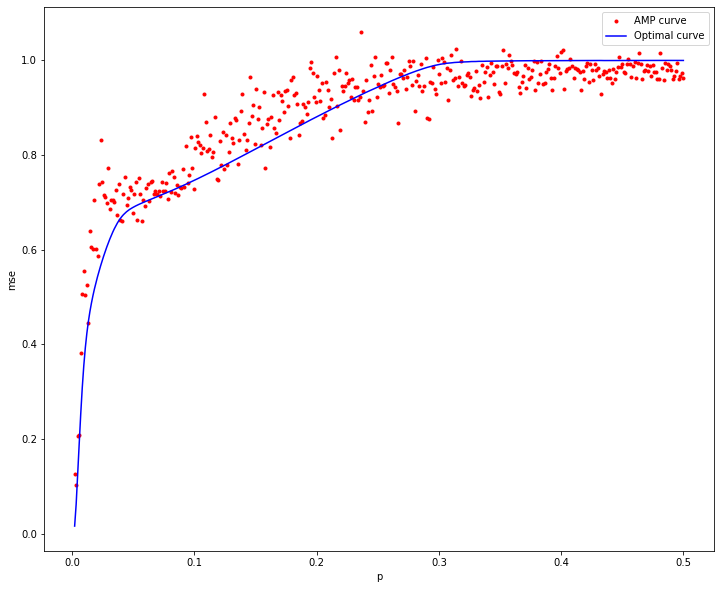

In [5]:
N = 100
start = 0.002
end = 0.5
points = 400
prior = 'rademacher'
proportions = [0.3, 0.2, 0.5]
sizes = [int(N * proportion) for proportion in proportions]
sizes[-1] += (N - sum(sizes))

off_diag = 500
block_delta = np.array([[1, off_diag, off_diag], [off_diag, 5, off_diag], [off_diag, off_diag, 50]])
delta_collection = create_block_matrix_collection(start, end, points, sizes, block_delta)

def create_object(object_type):
    if(object_type == 'amp'):
        amp_curve = data (seeds = 7, dimension = N, delta_collection = delta_collection, 
                 initialisation = 'spectral', prior = prior, algorithm = 'amp')
        result = {'curve': amp_curve, 'color': 'red', 'marking': '.', 'label' : 'AMP'}
    elif (object_type == 'spectral'):
        spectral_curve = data (seeds = 7, dimension = N,
                        delta_collection = delta_collection, prior = prior, algorithm = 'spectral')
        result = {'curve': spectral_curve, 'color': 'green', 'marking': '.', 'label' : 'Spectral'}
    else:
        optimal = optimal_curve(start, end, points, 
                              proportions, block_delta, prior = prior)
        result = {'curve': optimal, 'color': 'blue', 'marking': '-y', 'label' : 'Optimal curve'}
    return result

visualize([create_object('amp'), create_object('optimal')])